In [1]:
import os
import numpy as np
import pandas as pd

import lightning.pytorch as pl
import torch

from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from tensorboard import program
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import EncoderNormalizer
from pytorch_forecasting.metrics import QuantileLoss, MAE, SMAPE #, PoissonLoss

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import os
print("Current Working Directory:", os.getcwd())

/home/daokedao999/miniconda3/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Current Working Directory: /home/daokedao999/.local/share/jupyter/kernels/myenv


In [2]:
# Create the 'time_idx' column with incremental values from 0 to 99
time_idx = np.arange(100)

# Create the 'values' column with values representing a sine wave
time_points = np.linspace(0, 2, 100)
values = np.sin(time_points)

# Create the 'group_ids' column with a constant value of 66
#group1 = np.full(50, 11)
#group2 = np.full(30, 22)
#group3 = np.full(20, 33)

#group_ids = np.concatenate((group1, group2, group3), axis = 0)

# Combine the columns into a dictionary
data = {'time_idx': time_idx, 'vals': values, 'group_ids': 66}

# Create the DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df.head(10))
print(df.shape)
print(df.dtypes)

   time_idx      vals  group_ids
0         0  0.000000         66
1         1  0.020201         66
2         2  0.040393         66
3         3  0.060569         66
4         4  0.080720         66
5         5  0.100838         66
6         6  0.120916         66
7         7  0.140943         66
8         8  0.160914         66
9         9  0.180818         66
(100, 3)
time_idx       int64
vals         float64
group_ids      int64
dtype: object


In [3]:
#data slicing
training_cutoff = 50
train_df = df[lambda x: x.time_idx < training_cutoff]
val_df = df[lambda x: (x.time_idx >= training_cutoff) & (x.time_idx < 80)]
test_df = df[lambda x: x.time_idx >= 80]

print(f"""
train_df shape: {train_df.shape}
val_df shape: {val_df.shape}
test_df shape: {test_df.shape}
""")


train_df shape: (50, 3)
val_df shape: (30, 3)
test_df shape: (20, 3)



In [4]:
print(f"""check any NaN in the data:
        train_df: {train_df.isna().any().any()}
        val_df: {val_df.isna().any().any()}
        test_df: {test_df.isna().any().any()}
        """)

check any NaN in the data:
        train_df: False
        val_df: False
        test_df: False
        


In [5]:
print(f"""any inf in data:
        train_df: {train_df.isin([-np.inf, np.inf]).any().any()}
        val_df: {val_df.isin([-np.inf, np.inf]).any().any()}
        test_df: {test_df.isin([-np.inf, np.inf]).any().any()}
        """)

any inf in data:
        train_df: False
        val_df: False
        test_df: False
        


In [6]:
# Create the TimeSeriesDataSet
train_dataset = TimeSeriesDataSet(
    train_df,
    group_ids=["group_ids"],
    target="vals",
    time_idx="time_idx",
    max_encoder_length = 5,
    max_prediction_length = 2,
    time_varying_unknown_reals=["vals"],
    target_normalizer=EncoderNormalizer(transformation="softplus")
)

In [7]:
val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    val_df
)
test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_df
)

In [ ]:
train_dataloader = train_dataset.to_dataloader(
    train=False, #keep the "train=False" is to sliding through the whole dataset
    batch_size=100 #make the "batch size" >> than the dataset size is to align with the sliding window effect
)
val_dataloader = val_dataset.to_dataloader(
    train=False,
    batch_size=100
)
test_dataloader = test_dataset.to_dataloader(
    train=False,
    batch_size=100
)

In [9]:
pl.seed_everything(666)

lr_tune_logger = TensorBoardLogger(save_dir = "", version = "lr")  # logging results to the current pwd
lr_early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, mode="min"
)

#set up trainer for tunning
lr_trainer = pl.Trainer(
    accelerator = "gpu",
    devices = "auto",
    gradient_clip_val = 0.1,
    #fast_dev_run=True,  # comment in for debugging, only 1 training and 1 validation batch to run
    callbacks=[lr_early_stop_callback],
    logger = lr_tune_logger #if the logger is not set, the default loger will be saved under default name = version_0
)

#set up tft for tunning 
tft_tuner = TemporalFusionTransformer.from_dataset(
    train_dataset,
    # dummy lr required for the following lr_finder initiation
    learning_rate = 0.06,
    hidden_size = 8,  # most important hyperparameter apart from learning rate
    lstm_layers = 2,  # set to 2 or 3 for large datasets
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size = 2,
    dropout = 0.1,  # between 0.1 and 0.3 are good values
    loss = QuantileLoss(), 
    #quantiles = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98] as defined in `pytorch_forecasting.metrics.quantile.QuantileLoss` source code
    reduce_on_plateau_patience = 100
)
print(f"Number of parameters in network: {tft_tuner.size() / 1e3:.3f}k")

Seed set to 666
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 5.267k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]
Learning rate set to 0.012589254117941664
Restoring states from the checkpoint path at /home/daokedao999/.local/share/jupyter/kernels/myenv/.lr_find_a3c0939a-de4d-4e16-b0e5-640ad44f0d73.ckpt
Restored all states from the checkpoint at /home/daokedao999/.local/share/jupyter/kernels/myenv/.lr_find_a3c0939a-de4d-4e16-b0e5-640ad44f0d73.ckpt


suggested learning rate: 0.012589254117941664


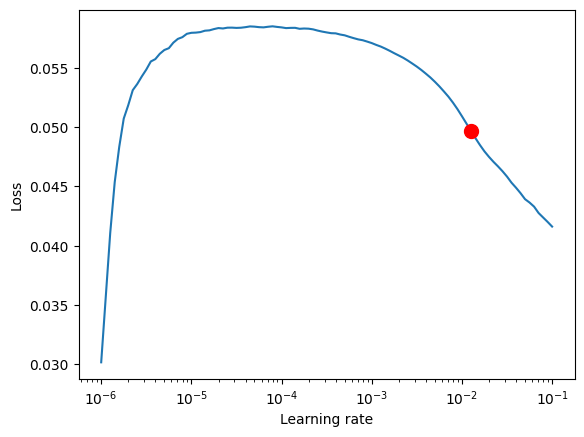

In [10]:
# learning rate optimization
lr_tuner = Tuner(lr_trainer).lr_find(
    tft_tuner,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
    max_lr = 0.1,
    min_lr = 1e-6,
)

print(f"suggested learning rate: {lr_tuner.suggestion()}")
fig = lr_tuner.plot(show=True, suggest=True)
fig.show()

In [11]:
#set up trainer for training
logger = TensorBoardLogger(save_dir = "", version = "train")  # logging results to the current pwd
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, mode="min"
)

trainer = pl.Trainer(
    accelerator = "gpu",
    devices = -1,
    gradient_clip_val = 0.1,
    #fast_dev_run=True,  # comment in for debugging, only 1 training and 1 validation batch to run
    callbacks=[early_stop_callback],
    logger = logger,
)

#set up tft for taining
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate = lr_tuner.suggestion(),
    hidden_size = 8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size = 2,
    lstm_layers = 2,  # set to 2 or 3 for large datasets
    dropout = 0.1,  # between 0.1 and 0.3 are good values
    loss = QuantileLoss(),
    reduce_on_plateau_patience = 100
)
print(f"Number of parameters in network: {tft.size() / 1e3:.3f}k") 

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 5.267k


In [12]:
# fit network
trainer.fit(
    tft,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 320    | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 304    | train
8  | static_context_initial_hidden_lstm |

Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s, v_num=rain, train_loss_step=0.0225, val_loss=0.0044, train_loss_epoch=0.0225] 


In [ ]:
#open tensorboard to check the results
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', 'lightning_logs', '--port', '6006'])
print("TensorBoard running at http://localhost:6006/")
tb.main()

In [13]:
#load the best model according to the validation loss
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [14]:
#check the metrics on val_dataset
trainer.validate(best_tft, dataloaders=val_dataloader)#, ckpt_path=best_model_path)
#the "ckpt_path" argument is not necessary, but it is good practice to load the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │     0.008423394523561     │
│         val_MAPE          │   0.008875485509634018    │
│         val_RMSE          │   0.010106625035405159    │
│         val_SMAPE         │   0.008933818899095058    │
│         val_loss          │    0.00440498860552907    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.00440498860552907,
  'val_SMAPE': 0.008933818899095058,
  'val_MAE': 0.008423394523561,
  'val_RMSE': 0.010106625035405159,
  'val_MAPE': 0.008875485509634018}]

In [15]:
#test_pred = best_tft.predict(test_dataloader, return_y=True)
#test_pred_x = best_tft.predict(test_dataloader, return_x=True)
test_pred_x_raw = best_tft.predict(test_dataloader, mode="raw", return_x=True, return_y=True) #incldue the attension weights

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [17]:
SMAPE(reduction=None).loss(test_pred.output,test_pred.y[0]).mean(1) #the "output" is the median prediction

In [18]:
test_pred_x_raw #the outputs are quantile predictions comparing the single prediction of "test_pred"

In [21]:
test_pred_x_raw.output.prediction.shape #the quantile predictions, the median = test_pred.output
#the "output" is a dictionary, the "prediction" is a tensor with the shape of (batch_size, prediction_length, num_quantiles)
#the quantiles = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98] as defined in `pytorch_forecasting.metrics.quantile.QuantileLoss` source code

In [16]:
#to prove above statement：
results = True
for b in range(test_pred.output.shape[0]):
    results_check = (test_pred_x_raw.output.prediction[b, :, 3] == test_pred.output[b,...]).all()
if not results_check:
    results = False
    print(f"NO, the output is not equal to the median prediction")
else:
    print(f"YES, the output is equal to the median prediction")

NameError: name 'test_pred' is not defined

In [32]:
test_pred_x_raw.y[0].shape

In [101]:
test_pred_x_raw.output.keys()

In [100]:
test_pred_x_raw.output.prediction.shape

In [26]:
test_pred_x_raw.x.keys()

In [31]:
test_pred_x_raw.x["decoder_target"].shape

In [30]:
print(torch.equal(test_pred_x_raw.x["decoder_target"],test_pred_x_raw.y[0]))

True


In [17]:
stacked_true = torch.stack([test_pred_x_raw.x["decoder_time_idx"], test_pred_x_raw.y[0]], dim=2)
stacked_true = stacked_true.reshape(-1, 2)
stacked_true = stacked_true.unique(dim=0)
print(stacked_true.shape)

torch.Size([15, 2])


In [18]:
stack_check=stacked_true[:,1].reshape(-1,1).cpu() #the model is on "GPU" needs to be move to "CPU"

In [19]:
test_val=torch.tensor(test_df[test_df["time_idx"] >= 85]["vals"].values).unsqueeze(1)
test_val.shape

torch.Size([15, 1])

In [60]:
test_plot=torch.tensor(test_df[test_df["time_idx"] >= 85]["vals"].values)
test_plot.shape

torch.Size([15])

In [20]:
sum(test_val-stack_check) #the difference is caused by the "TimeSeriesDataSet".

tensor([7.3585e-08], dtype=torch.float64)

In [21]:
sum(test_val-test_pred_x_raw.y[0].reshape(-1, 1).unique(dim=0).cpu())

tensor([7.3585e-08], dtype=torch.float64)

In [53]:
#results plotting function
def plot_single_timeseries_quantile_predictions(tensor1_preds, tensor2_actuals,
                                                quantile_levels=None, quantile_labels=None,
                                                title="Time Series Quantile Prediction"):
    """
    Plots quantile predictions (tensor1_preds) against actual values (tensor2_actuals)
    for a single time series.

    Args:
        tensor1_preds (np.ndarray): Quantile predictions. Shape: [time, features].
                                    Features are assumed to be sorted quantiles.
                                    Example for 7 features: [q0.02, q0.1, q0.25, q0.5, q0.75, q0.9, q0.98]
        tensor2_actuals (np.ndarray): Actual values. Shape: [time].
        quantile_levels (list of float, optional): The actual quantile levels corresponding
                                                   to the features in tensor1_preds.
                                                   Used for generating accurate default labels.
        quantile_labels (list of str, optional): Labels for the prediction intervals.
                                                 If None, default labels will be generated.
                                                 Order should correspond to outermost to innermost interval.
        title (str, optional): The title for the plot.
    """
    if tensor1_preds.ndim != 2:
        raise ValueError("tensor1_preds (predictions) must be 2D [time, features].")
    if tensor2_actuals.ndim != 1:
        raise ValueError("tensor2_actuals (actuals) must be 1D [time].")
    if tensor1_preds.shape[0] != tensor2_actuals.shape[0]:
        raise ValueError("Time dimension of tensor1_preds and tensor2_actuals must match.")

    num_time_steps = tensor1_preds.shape[0]
    num_features = tensor1_preds.shape[1]

    if num_features % 2 == 0:
        raise ValueError("Number of features in tensor1_preds must be odd to have a central median.")
    
    median_index = num_features // 2

    # Define quantile labels if not provided
    if quantile_labels is None:
        if num_features == 7 and quantile_levels and len(quantile_levels) == 7:
            # Generate labels based on provided quantile_levels
            # Assumes pairs are (0,6), (1,5), (2,4) for features
            pi1_lower, pi1_upper = quantile_levels[0], quantile_levels[6]
            pi2_lower, pi2_upper = quantile_levels[1], quantile_levels[5]
            pi3_lower, pi3_upper = quantile_levels[2], quantile_levels[4]
            
            quantile_labels = [
                f"{(pi1_upper - pi1_lower) * 100:.0f}% PI ({pi1_lower:.2f}-{pi1_upper:.2f})", # Outermost
                f"{(pi2_upper - pi2_lower) * 100:.0f}% PI ({pi2_lower:.2f}-{pi2_upper:.2f})", # Middle
                f"{(pi3_upper - pi3_lower) * 100:.0f}% PI ({pi3_lower:.2f}-{pi3_upper:.2f})"  # Innermost
            ]
        elif num_features == 7: # Default for 7 features if specific levels not given
             quantile_labels = ["96% PI (e.g., 0.02-0.98)", "80% PI (e.g., 0.1-0.9)", "50% PI (e.g., 0.25-0.75)"]
        else:
            # Fallback for a different number of features
            quantile_labels = [f"Interval {i+1}" for i in range(num_features // 2)]
    
    if len(quantile_labels) != num_features // 2:
        raise ValueError(f"Expected {num_features // 2} quantile labels, but got {len(quantile_labels)}.")

    # Set a nice seaborn style
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=(12, 6)) # Single plot

    time_indices = np.arange(num_time_steps)

    # Plot actual values
    ax.plot(time_indices, tensor2_actuals, label="Actual", color="black", marker='o', linestyle='-', zorder=num_features//2 + 2)

    # Plot median prediction (middle feature)
    median_prediction = tensor1_preds[:, median_index]
    median_label_text = f"Median ({quantile_levels[median_index]:.2f}Q)" if quantile_levels and median_index < len(quantile_levels) else "Median Prediction"
    ax.plot(time_indices, median_prediction, label=median_label_text, color="blue", marker='x', linestyle='--', zorder=num_features//2 + 1)

    # Plot prediction intervals
    # Intervals are formed by pairing features from outside in
    # e.g., for 7 features: (feature 0, feature 6), (feature 1, feature 5), (feature 2, feature 4)
    # Colors for intervals - from lighter to darker for better visual hierarchy
    # Using a list of distinct, visually pleasing colors for intervals
    interval_palette = sns.color_palette("Blues", n_colors=num_features // 2 + 2) # Get a few shades
    
    # The quantile_labels should be ordered from outermost to innermost.
    # The loop for j goes from 0 (outermost interval) to (num_features // 2 - 1) (innermost interval).
    for j in range(num_features // 2):
        lower_quantile_idx = j
        upper_quantile_idx = num_features - 1 - j
        
        # Assign colors such that the widest interval is lightest, narrowest is darkest within the theme
        # So, interval_colors[j] means the j-th interval (0 = outermost) gets a progressively darker shade.
        # The label quantile_labels[j] should correspond to this j-th interval.
        ax.fill_between(time_indices, tensor1_preds[:, lower_quantile_idx], tensor1_preds[:, upper_quantile_idx],
                        color=interval_palette[j], # interval_palette[0] is light, interval_palette[num_features//2 -1] is darker
                        alpha=0.3 + (j * 0.1), # Alpha can also increase for inner bands if desired
                        label=quantile_labels[j], 
                        zorder=j+1)


    ax.set_title(title)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")

    if num_time_steps <= 20: # Show markers if not too many time steps
        ax.set_xticks(time_indices)
    else: # Otherwise, let matplotlib decide tick locations for readability
        pass

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    # Custom sort order for legend: Actual, Median, then PIs (already ordered by plotting)
    # If specific order is needed and not achieved by plotting order:
    # order_preference = ["Actual", median_label_text] + quantile_labels
    # sorted_legend = sorted(zip(handles, labels), key=lambda x: order_preference.index(x[1]) if x[1] in order_preference else float('inf'))
    # handles = [h for h, l in sorted_legend]
    # labels = [l for h, l in sorted_legend]
    ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 1))


    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend outside
    plt.show()

In [23]:
pred=test_pred_x_raw.output.prediction.reshape(-1, 7)
pred.shape

torch.Size([28, 7])

In [24]:
#check the reshape did not break the order of data
diff=torch.empty(size=(14,1))
for i in range(13):
    diff[i]=sum(sum(pred[0+i*2:2+i*2,]-test_pred_x_raw.output.prediction[i,...])).cpu()
sum(diff)

tensor([0.])

In [37]:
time_idx=test_pred_x_raw.x["decoder_time_idx"].reshape(-1, 1)

In [ ]:
pred=torch.cat((time_idx, pred), dim=1) #add the time index of the predictions as col=0
pred.shape

torch.Size([28, 8])

In [47]:
pred

tensor([[85.0000,  0.9963,  0.9976,  0.9977,  0.9986,  0.9990,  1.0012,  1.0040],
        [86.0000,  0.9963,  0.9975,  0.9976,  0.9986,  0.9990,  1.0013,  1.0041],
        [86.0000,  0.9944,  0.9960,  0.9961,  0.9974,  0.9978,  1.0006,  1.0040],
        [87.0000,  0.9945,  0.9959,  0.9960,  0.9974,  0.9978,  1.0006,  1.0041],
        [87.0000,  0.9922,  0.9941,  0.9942,  0.9957,  0.9962,  0.9995,  1.0036],
        [88.0000,  0.9923,  0.9940,  0.9941,  0.9957,  0.9963,  0.9996,  1.0036],
        [88.0000,  0.9895,  0.9917,  0.9918,  0.9936,  0.9942,  0.9980,  1.0027],
        [89.0000,  0.9896,  0.9916,  0.9917,  0.9936,  0.9943,  0.9981,  1.0028],
        [89.0000,  0.9864,  0.9889,  0.9891,  0.9911,  0.9917,  0.9961,  1.0015],
        [90.0000,  0.9866,  0.9888,  0.9890,  0.9911,  0.9919,  0.9963,  1.0015],
        [90.0000,  0.9830,  0.9857,  0.9859,  0.9882,  0.9889,  0.9938,  0.9998],
        [91.0000,  0.9831,  0.9856,  0.9858,  0.9883,  0.9890,  0.9940,  0.9999],
        [91.0000

In [49]:
#create a function to get the avg of the duplicate rows
def average_duplicate_rows(tensor, column_index):
    """
    Calculates the average of other columns for duplicate rows based on values in a specified column.

    Args:
        tensor: A 2D PyTorch tensor.
        column_index: The index of the column used for identifying duplicate rows.

    Returns:
        A new tensor with averaged rows.
    """

    if tensor.ndim != 2:
      raise ValueError("Input tensor must be 2D.")
    
    if column_index >= tensor.shape[1]:
        raise IndexError("column_index out of range")
    
    # Convert to NumPy array for easier manipulation
    tensor_np = tensor.numpy()

    # Get unique values in the specified column and their indices
    unique_values, inverse_indices = torch.unique(tensor[:, column_index], return_inverse=True)
    unique_values = unique_values.numpy()
    inverse_indices = inverse_indices.numpy()

    # Create a dictionary to store rows for each unique value
    grouped_rows = {}
    for i, val in enumerate(inverse_indices):
        if val not in grouped_rows:
          grouped_rows[val] = []
        grouped_rows[val].append(tensor_np[i])

    # Calculate the average of other columns for each group
    averaged_rows = []
    for _, rows in grouped_rows.items():
        rows = torch.tensor(rows) #convert list of rows to tensor
        averaged_row = rows.mean(dim=0)
        averaged_rows.append(averaged_row)
    
    averaged_rows = torch.stack(averaged_rows)

    return averaged_rows

In [51]:
pred_avg = average_duplicate_rows(pred.cpu(), 0)
pred_avg.shape

torch.Size([15, 8])

In [ ]:
pred_plot=pred_avg[:, 1:] #remove the time index column
pred_plot.shape

torch.Size([15, 7])

In [64]:
pred_plot

tensor([[0.9963, 0.9976, 0.9977, 0.9986, 0.9990, 1.0012, 1.0040],
        [0.9954, 0.9968, 0.9969, 0.9980, 0.9984, 1.0009, 1.0040],
        [0.9933, 0.9950, 0.9951, 0.9965, 0.9970, 1.0001, 1.0038],
        [0.9909, 0.9928, 0.9930, 0.9946, 0.9952, 0.9988, 1.0032],
        [0.9880, 0.9902, 0.9904, 0.9924, 0.9930, 0.9971, 1.0021],
        [0.9848, 0.9873, 0.9874, 0.9897, 0.9904, 0.9950, 1.0007],
        [0.9811, 0.9839, 0.9841, 0.9866, 0.9874, 0.9926, 0.9988],
        [0.9770, 0.9801, 0.9803, 0.9831, 0.9840, 0.9897, 0.9965],
        [0.9726, 0.9759, 0.9761, 0.9792, 0.9801, 0.9864, 0.9939],
        [0.9677, 0.9713, 0.9716, 0.9749, 0.9759, 0.9827, 0.9908],
        [0.9625, 0.9663, 0.9666, 0.9702, 0.9713, 0.9786, 0.9873],
        [0.9568, 0.9610, 0.9612, 0.9651, 0.9663, 0.9741, 0.9835],
        [0.9508, 0.9552, 0.9555, 0.9596, 0.9609, 0.9692, 0.9792],
        [0.9444, 0.9490, 0.9494, 0.9537, 0.9551, 0.9639, 0.9745],
        [0.9412, 0.9457, 0.9461, 0.9507, 0.9522, 0.9613, 0.9722]])

In [58]:
# --- Define Quantile Labels based on SPECIFIC_QUANTILE_LEVELS ---
# These labels will be passed to the plotting function.
SPECIFIC_QUANTILE_LEVELS= [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98] # The quantile levels used in the model

# The function can also generate them if quantile_levels are passed.
# Order: Outermost, Middle, Innermost
pi_outer_label = f"{(SPECIFIC_QUANTILE_LEVELS[6] - SPECIFIC_QUANTILE_LEVELS[0])*100:.0f}% PI ({SPECIFIC_QUANTILE_LEVELS[0]:.2f}-{SPECIFIC_QUANTILE_LEVELS[6]:.2f})"
pi_mid_label = f"{(SPECIFIC_QUANTILE_LEVELS[5] - SPECIFIC_QUANTILE_LEVELS[1])*100:.0f}% PI ({SPECIFIC_QUANTILE_LEVELS[1]:.2f}-{SPECIFIC_QUANTILE_LEVELS[5]:.2f})"
pi_inner_label = f"{(SPECIFIC_QUANTILE_LEVELS[4] - SPECIFIC_QUANTILE_LEVELS[2])*100:.0f}% PI ({SPECIFIC_QUANTILE_LEVELS[2]:.2f}-{SPECIFIC_QUANTILE_LEVELS[4]:.2f})"
    
# The order in custom_labels MUST match the order of plotting fill_between
# which is from outermost to innermost (j=0 to num_features//2 - 1)
custom_interval_labels = [pi_outer_label, pi_mid_label, pi_inner_label]

Tensor1 (predictions) shape: torch.Size([15, 7])
Tensor2 (actuals) shape: torch.Size([15])
Quantile levels being plotted: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]


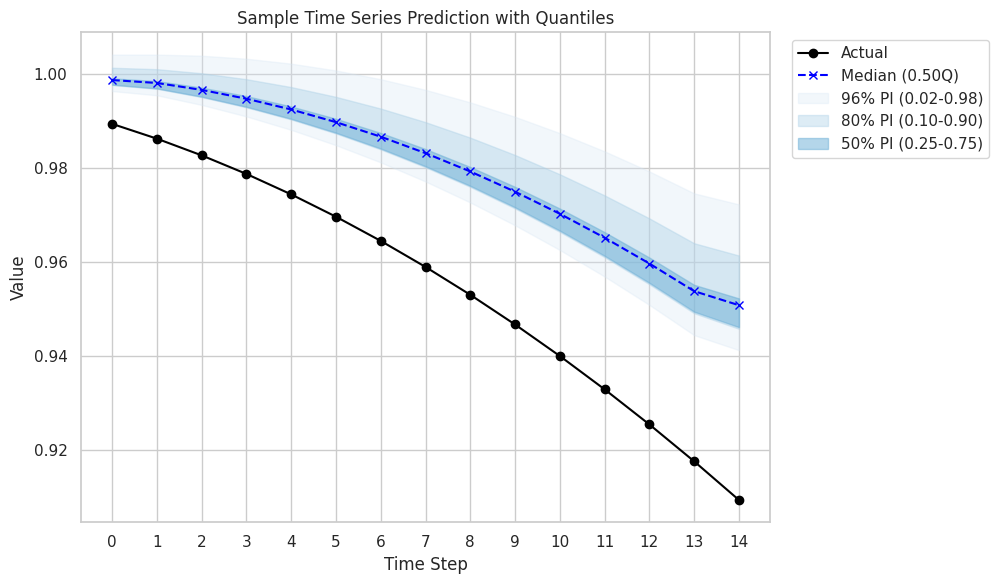

In [66]:
# --- Plot the Tensors ---
print(f"Tensor1 (predictions) shape: {pred_plot.shape}")
print(f"Tensor2 (actuals) shape: {test_plot.shape}")
print(f"Quantile levels being plotted: {SPECIFIC_QUANTILE_LEVELS}")

plot_single_timeseries_quantile_predictions(
    pred_plot,
    test_plot,
    quantile_levels=SPECIFIC_QUANTILE_LEVELS,
    quantile_labels=custom_interval_labels, # Pass the correctly ordered labels
    title="Sample Time Series Prediction with Quantiles"
)